In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_005"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 244
RE = True

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [6]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [7]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, Resize(448, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             size=size, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.25, 
                             pad_mode=PadMode.Zeros,
                             min_scale=0.75)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing())
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

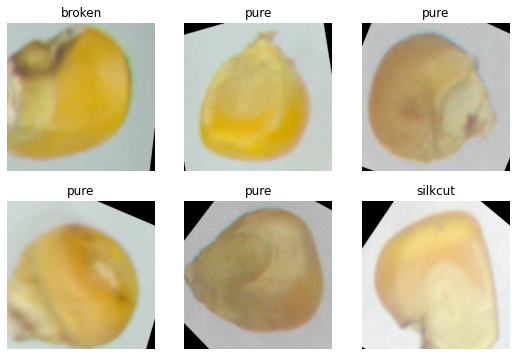

In [8]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [9]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [10]:
# set_seed(42);set_fast_norm()

# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
#     dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
#     learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
#                 loss_func=CrossEntropyLossFlat(), metrics=[accuracy], splitter=default_split).to_fp16()
    
#     print(learn.lr_find(suggest_funcs=(valley, slide)))

In [11]:
n_epo = 10; base_lr = 5e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_default_split_ft"
set_seed(42); set_fast_norm()

In [12]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            wandb.define_metric('accuracy', hidden=False, summary="max")
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=default_split).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),WandbCallback(log_preds=None)]
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.025748,0.844171,0.673298,00:34


Better model found at epoch 0 with accuracy value: 0.6732984185218811.


epoch,train_loss,valid_loss,accuracy,time
0,0.768247,0.684464,0.727749,00:44
1,0.724466,0.659990,0.745201,00:44
2,0.720068,0.603062,0.763351,00:44
3,0.673997,0.568123,0.773473,00:44
4,0.653461,0.558352,0.779407,00:44
5,0.595848,0.539328,0.787435,00:44
6,0.547249,0.505748,0.798255,00:44
7,0.506496,0.502860,0.796859,00:44
8,0.491454,0.493698,0.796510,00:44
9,0.501947,0.490992,0.800000,00:45


Better model found at epoch 0 with accuracy value: 0.727748692035675.
Better model found at epoch 1 with accuracy value: 0.7452006936073303.
Better model found at epoch 2 with accuracy value: 0.763350784778595.
Better model found at epoch 3 with accuracy value: 0.7734729647636414.
Better model found at epoch 4 with accuracy value: 0.7794066071510315.
Better model found at epoch 5 with accuracy value: 0.7874345779418945.
Better model found at epoch 6 with accuracy value: 0.7982547879219055.
Better model found at epoch 9 with accuracy value: 0.800000011920929.
CPU: 774/71/3686 MB | GPU: 902/2020/7041 MB | Time 0:08:19.939 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.064449,0.962081,0.627225,00:34


Better model found at epoch 0 with accuracy value: 0.6272251605987549.


epoch,train_loss,valid_loss,accuracy,time
0,0.774835,0.654620,0.733333,00:44
1,0.720900,0.634149,0.753578,00:44
2,0.750275,0.595148,0.766492,00:45
3,0.630850,0.627573,0.750785,00:44
4,0.662870,0.530893,0.787086,00:44
5,0.586685,0.531169,0.786387,00:44
6,0.594317,0.509591,0.796161,00:44
7,0.517712,0.492779,0.804538,00:45
8,0.504325,0.484637,0.804188,00:44
9,0.524907,0.487087,0.801396,00:45


Better model found at epoch 0 with accuracy value: 0.7333333492279053.
Better model found at epoch 1 with accuracy value: 0.7535776495933533.
Better model found at epoch 2 with accuracy value: 0.7664921283721924.
Better model found at epoch 4 with accuracy value: 0.7870855331420898.
Better model found at epoch 6 with accuracy value: 0.7961605787277222.
Better model found at epoch 7 with accuracy value: 0.8045375347137451.
CPU: 114/72/3800 MB | GPU: 58/2444/7099 MB | Time 0:08:18.937 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.039456,0.819374,0.675628,00:34


Better model found at epoch 0 with accuracy value: 0.6756284832954407.


epoch,train_loss,valid_loss,accuracy,time
0,0.781091,0.669885,0.734637,00:45
1,0.767056,0.625705,0.741271,00:45
2,0.702781,0.668028,0.730447,00:45
3,0.648443,0.597315,0.761522,00:45
4,0.622873,0.603458,0.763268,00:45
5,0.579409,0.540753,0.787709,00:45
6,0.518700,0.567545,0.780726,00:45
7,0.536760,0.511034,0.803771,00:45
8,0.503663,0.501767,0.806215,00:45
9,0.497231,0.506924,0.800628,00:45


Better model found at epoch 0 with accuracy value: 0.7346368432044983.
Better model found at epoch 1 with accuracy value: 0.7412709593772888.
Better model found at epoch 3 with accuracy value: 0.7615223526954651.
Better model found at epoch 4 with accuracy value: 0.7632681727409363.
Better model found at epoch 5 with accuracy value: 0.7877094745635986.
Better model found at epoch 7 with accuracy value: 0.8037709593772888.
Better model found at epoch 8 with accuracy value: 0.8062151074409485.
CPU: 114/51/3914 MB | GPU: 182/2246/7281 MB | Time 0:08:21.648 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.065573,0.838043,0.663757,00:34


Better model found at epoch 0 with accuracy value: 0.6637569665908813.


epoch,train_loss,valid_loss,accuracy,time
0,0.773571,0.638175,0.737779,00:45
1,0.764684,0.646691,0.741620,00:45
2,0.707156,0.564558,0.772346,00:45
3,0.666755,0.545958,0.773394,00:45
4,0.657865,0.523289,0.795740,00:44
5,0.604766,0.497038,0.797835,00:45
6,0.553535,0.482462,0.819832,00:45
7,0.541243,0.473219,0.815992,00:45
8,0.491892,0.467859,0.817737,00:45
9,0.510565,0.460022,0.820880,00:45


Better model found at epoch 0 with accuracy value: 0.7377793192863464.
Better model found at epoch 1 with accuracy value: 0.7416201233863831.
Better model found at epoch 2 with accuracy value: 0.7723463773727417.
Better model found at epoch 3 with accuracy value: 0.7733938694000244.
Better model found at epoch 4 with accuracy value: 0.7957402467727661.
Better model found at epoch 5 with accuracy value: 0.7978351712226868.
Better model found at epoch 6 with accuracy value: 0.8198323845863342.
Better model found at epoch 9 with accuracy value: 0.8208798766136169.
CPU: -94/48/3820 MB | GPU: 26/2254/7307 MB | Time 0:08:21.251 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.061808,0.992482,0.638268,00:34


Better model found at epoch 0 with accuracy value: 0.6382681727409363.


epoch,train_loss,valid_loss,accuracy,time
0,0.804367,0.649475,0.743017,00:45
1,0.739273,0.590231,0.763967,00:45
2,0.718480,0.670696,0.741271,00:45
3,0.643734,0.568617,0.770251,00:45
4,0.622055,0.541464,0.781425,00:45
5,0.618977,0.524012,0.785964,00:45
6,0.554226,0.508692,0.795391,00:45
7,0.552835,0.505274,0.795740,00:45
8,0.511657,0.468319,0.809707,00:45
9,0.518056,0.470300,0.805517,00:45


Better model found at epoch 0 with accuracy value: 0.74301677942276.
Better model found at epoch 1 with accuracy value: 0.7639665007591248.
Better model found at epoch 3 with accuracy value: 0.7702513933181763.
Better model found at epoch 4 with accuracy value: 0.7814245820045471.
Better model found at epoch 5 with accuracy value: 0.7859637141227722.
Better model found at epoch 6 with accuracy value: 0.7953910827636719.
Better model found at epoch 7 with accuracy value: 0.7957402467727661.
Better model found at epoch 8 with accuracy value: 0.8097066879272461.
CPU: 19/57/3839 MB | GPU: 166/2088/7473 MB | Time 0:08:23.585 | (Consumed/Peaked/Used Total)


In [13]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=timm_split, model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # original dl with validation tfms
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        # dl with hflip
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        # dl with vflip tfms
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80524, 0.80663, 0.80866, 0.82682, 0.81634]
Avg: 0.81274
Std: 0.00802


In [21]:
# pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
# folds_val_score = []

# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
#     for fold_index in range(NFOLDS):
#         dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

#         learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
#                                loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
#                                splitter=timm_split, model_dir=MODEL_FOLDER).to_fp16()
        
#         checkpoint = pattern.format(fold=fold_index)
#         print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
#         learn.load(checkpoint)
#         preds, targs = learn.tta(dl=dls.valid, n=15, beta=0)
        
# #         # original dl with validation tfms
# #         tst_dl = dls.valid.new()
# #         with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
# #             preds0, targs = learn.get_preds(dl=tst_dl)
        
# #         # dl with hflip
# #         tst_dl_1 = dls.valid.new()
# #         tst_dl_1.after_batch.add(hflip)
# #         with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
# #             preds1, _ = learn.get_preds(dl=tst_dl_1)
        
# #         # dl with vflip tfms
# #         tst_dl_2 = dls.valid.new()
# #         tst_dl_2.after_batch.add(vflip)
# #         with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
# #             preds2, _ = learn.get_preds(dl=tst_dl_2)
        
# #         preds = (preds0+preds1+preds2)/3
#         acc = accuracy(preds, targs).item()
        
#         folds_val_score.append(acc)

# disp.clear_output()    
# print("============ Run summary ============")
# print("folds score: ", [np.round(s, 5) for s in folds_val_score])
# print("Avg: {:.5f}".format(np.mean(folds_val_score)))
# print("Std: {:.5f}".format(np.std(folds_val_score)))